In [9]:
import atoti as tt

In [10]:
session = tt.Session()

Closing existing "Unnamed" session to create the new one.


In [11]:
jdbc_url = "jdbc:postgresql://pgdb:5432/AdventureworksDWDemo?user=postgres&password=postgres"

In [12]:
product_sales_table = session.read_sql(
    "SELECT * FROM factproductsales",
    keys=["transactionid"],
    table_name="ProductSales",
    url=jdbc_url,
)

customer_table = session.read_sql(
    "SELECT * FROM dimcustomer",
    keys=["customerid"],
    table_name="Customer",
    url=jdbc_url)
    
product_table = session.read_sql(
    "SELECT * FROM dimproduct",
    keys=["productkey"],
    table_name="Product",
    url=jdbc_url
)

sales_person_table = session.read_sql(
    "SELECT * FROM dimsalesperson",
    keys=["salespersonid"],
    table_name="SalesPerson",
    url=jdbc_url
)

stores_table = session.read_sql(
    "SELECT * FROM dimstores",
    keys=["storeid"],
    table_name="Stores",
    url=jdbc_url
)

## Implement Star Schema

In [13]:
product_sales_table.join(customer_table, product_sales_table["customerid"] == customer_table["customerid"])

product_sales_table.join(product_table, product_sales_table["productid"] == product_table["productkey"])

product_sales_table.join(sales_person_table, product_sales_table["salespersonid"] == sales_person_table["salespersonid"])

product_sales_table.join(stores_table, product_sales_table["storeid"] == stores_table["storeid"])

## Draw Schema

In [14]:
session.tables.schema

```mermaid
erDiagram
  "Customer" {
    _ int PK "customerid"
    _ String "customeraltid"
    _ String "customername"
    _ String "gender"
  }
  "SalesPerson" {
    _ int PK "salespersonid"
    _ String "salespersonaltid"
    _ String "salespersonname"
    nullable int "storeid"
    _ String "city"
    _ String "state"
    _ String "country"
  }
  "Product" {
    _ int PK "productkey"
    _ String "productaltkey"
    _ String "productname"
    nullable double "productactualcost"
    nullable double "productsalescost"
  }
  "Stores" {
    _ int PK "storeid"
    _ String "storealtid"
    _ String "storename"
    _ String "storelocation"
    _ String "city"
    _ String "state"
    _ String "country"
  }
  "ProductSales" {
    _ long PK "transactionid"
    nullable int "salesinvoicenumber"
    nullable int "storeid"
    nullable int "customerid"
    nullable int "productid"
    nullable int "salespersonid"
    nullable double "quantity"
    nullable double "salestotalcost"
    nullable double "productactualcost"
    nullable double "deviation"
  }
  "ProductSales" }o--o| "Product" : "`productid` == `productkey`"
  "ProductSales" }o--o| "Customer" : "`customerid` == `customerid`"
  "ProductSales" }o--o| "SalesPerson" : "`salespersonid` == `salespersonid`"
  "ProductSales" }o--o| "Stores" : "`storeid` == `storeid`"
```


## Create Cube

In order to do some OLAP analysis such as **roll up** and **drill down**

In [7]:
cube = session.create_cube(product_sales_table)
cube

## Create Hierarchies

In [8]:
hierarchies, levels, measures = cube.hierarchies, cube.levels, cube.measures
hierarchies

{('Stores', 'storename'): <atoti.hierarchy.Hierarchy object at 0x7fcf71eff490>, ('Stores', 'state'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f28e90>, ('Product', 'productname'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3b890>, ('SalesPerson', 'city'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3b990>, ('Product', 'productaltkey'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3ba90>, ('SalesPerson', 'salespersonaltid'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3bb90>, ('Stores', 'storealtid'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3bc90>, ('Stores', 'city'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3bd90>, ('ProductSales', 'transactionid'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3be90>, ('Customer', 'customername'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f3bf90>, ('SalesPerson', 'salespersonname'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f440d0>, ('SalesPerson', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f441d0>, ('Customer', 'customeraltid'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f442d0>, ('Stores', 'storelocation'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f443d0>, ('SalesPerson', 'state'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f444d0>, ('Stores', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f445d0>, ('Customer', 'gender'): <atoti.hierarchy.Hierarchy object at 0x7fcf71f446d0>}

Can see the auto made hierarchy is not correct

### Fix the error

**Hierarchies**
- did drill-down path (country-state-city)
- removed unnecessaty hierarchy like 'customeraltid' and 'productaltkey' as it may not be useful for analysis 


**Levels**
- having 'customername' and 'gender' under the 'Customer' hierarchy allow analysis across these 2 dimensions
- 'SalesPerson' and 'Stores' include geo info, std prac for sales data analysis, allow geo insights

**Measures**
- removed not likely needed measure (like avg, and sums of IDs)
- remaining measures like 'productactualcost.SUM', 'quantity.SUM' and 'salestotalcost.SUM' typical fact table as they represent additive quantities that can be summed across various dimensions.

In [9]:
hierarchies["Customer"] = [levels["customername"], levels["gender"]]

hierarchies["Product"] = [levels["productname"]]

# can see the drill-down paths (country-state-city)
hierarchies["SalesPerson"] = [levels["salespersonname"], levels[('SalesPerson', 'city', 'city')], levels[('SalesPerson', 'state', 'state')], levels[('SalesPerson', 'country', 'country')]]

hierarchies["Stores"] = [levels[('Stores', 'storename', 'storename')], levels[('Stores', 'city', 'city')], levels[('Stores', 'state', 'state')], levels[('Stores', 'country', 'country')]]

In [10]:
# clean customer
del hierarchies[('Customer', 'customeraltid')]
del hierarchies[('Customer', 'customername')]
del hierarchies[('Customer', 'gender')]

In [11]:
# clean product
del hierarchies[('Product', 'productname')]
del hierarchies[('Product', 'productaltkey')]

In [12]:
# clean salesperson
del hierarchies[('SalesPerson', 'city')]
del hierarchies[('SalesPerson', 'salespersonname')]
del hierarchies[('SalesPerson', 'country')]
del hierarchies[('SalesPerson', 'state')]
del hierarchies[('SalesPerson', 'salespersonaltid')]

In [13]:
# clean stores
del hierarchies[('Stores', 'storename')]
del hierarchies[('Stores', 'state')]
del hierarchies[('Stores', 'country')]
del hierarchies[('Stores', 'storealtid')]
del hierarchies[('Stores', 'city')]

In [14]:
# clean product sales
del hierarchies[('ProductSales', 'transactionid')]

# Check hierarchies
hierarchies

{('SalesPerson', 'SalesPerson'): <atoti.hierarchy.Hierarchy object at 0x7ff282cc3690>, ('Stores', 'Stores'): <atoti.hierarchy.Hierarchy object at 0x7ff282ca8150>, ('Product', 'Product'): <atoti.hierarchy.Hierarchy object at 0x7ff282cec610>, ('Customer', 'Customer'): <atoti.hierarchy.Hierarchy object at 0x7ff282cec150>, ('Stores', 'storelocation'): <atoti.hierarchy.Hierarchy object at 0x7ff282cec1d0>}

Measures also need to be cleaned (IDs shouldn't be used for calculation)

In [15]:
# clean measures
del measures["contributors.COUNT"]
del measures["customerid.MEAN"]
del measures["customerid.SUM"]
del measures["deviation.MEAN"]
del measures["deviation.SUM"]
del measures["productactualcost.MEAN"]
del measures["productid.MEAN"]
del measures["productid.SUM"]
del measures["salesinvoicenumber.MEAN"]
del measures["salesinvoicenumber.SUM"]
del measures["salespersonid.MEAN"]
del measures["salespersonid.SUM"]
del measures["storeid.MEAN"]
del measures["storeid.SUM"]
del measures["salestotalcost.MEAN"]
del measures["quantity.MEAN"]

# Check measures
measures

{'update.TIMESTAMP': <atoti.measure.Measure object at 0x7ff282cedbd0>, 'quantity.SUM': <atoti.measure.Measure object at 0x7ff282cec0d0>, 'salestotalcost.SUM': <atoti.measure.Measure object at 0x7ff282cec4d0>, 'productactualcost.SUM': <atoti.measure.Measure object at 0x7ff282cecd10>}

**How many X-Mart are in Ahmedabad?**

In [16]:
cube.query(measures["quantity.SUM"], levels=[levels[('Stores', 'Stores', 'city')]])

,,quantity.SUM
storename,city,
X-Mart,Ahmedabad,43.00


only needed the **levels[('Stores', 'Stores', 'city')]** to get the storename and city cause it rolls up from city to storename (storename-city-state-country) and there is only 1 X-Mart and 1 city.

# Draw a Starnet

Assume product named X, and product is selling in city Y.

How many units of Product X were purchased by female customers in City Y?
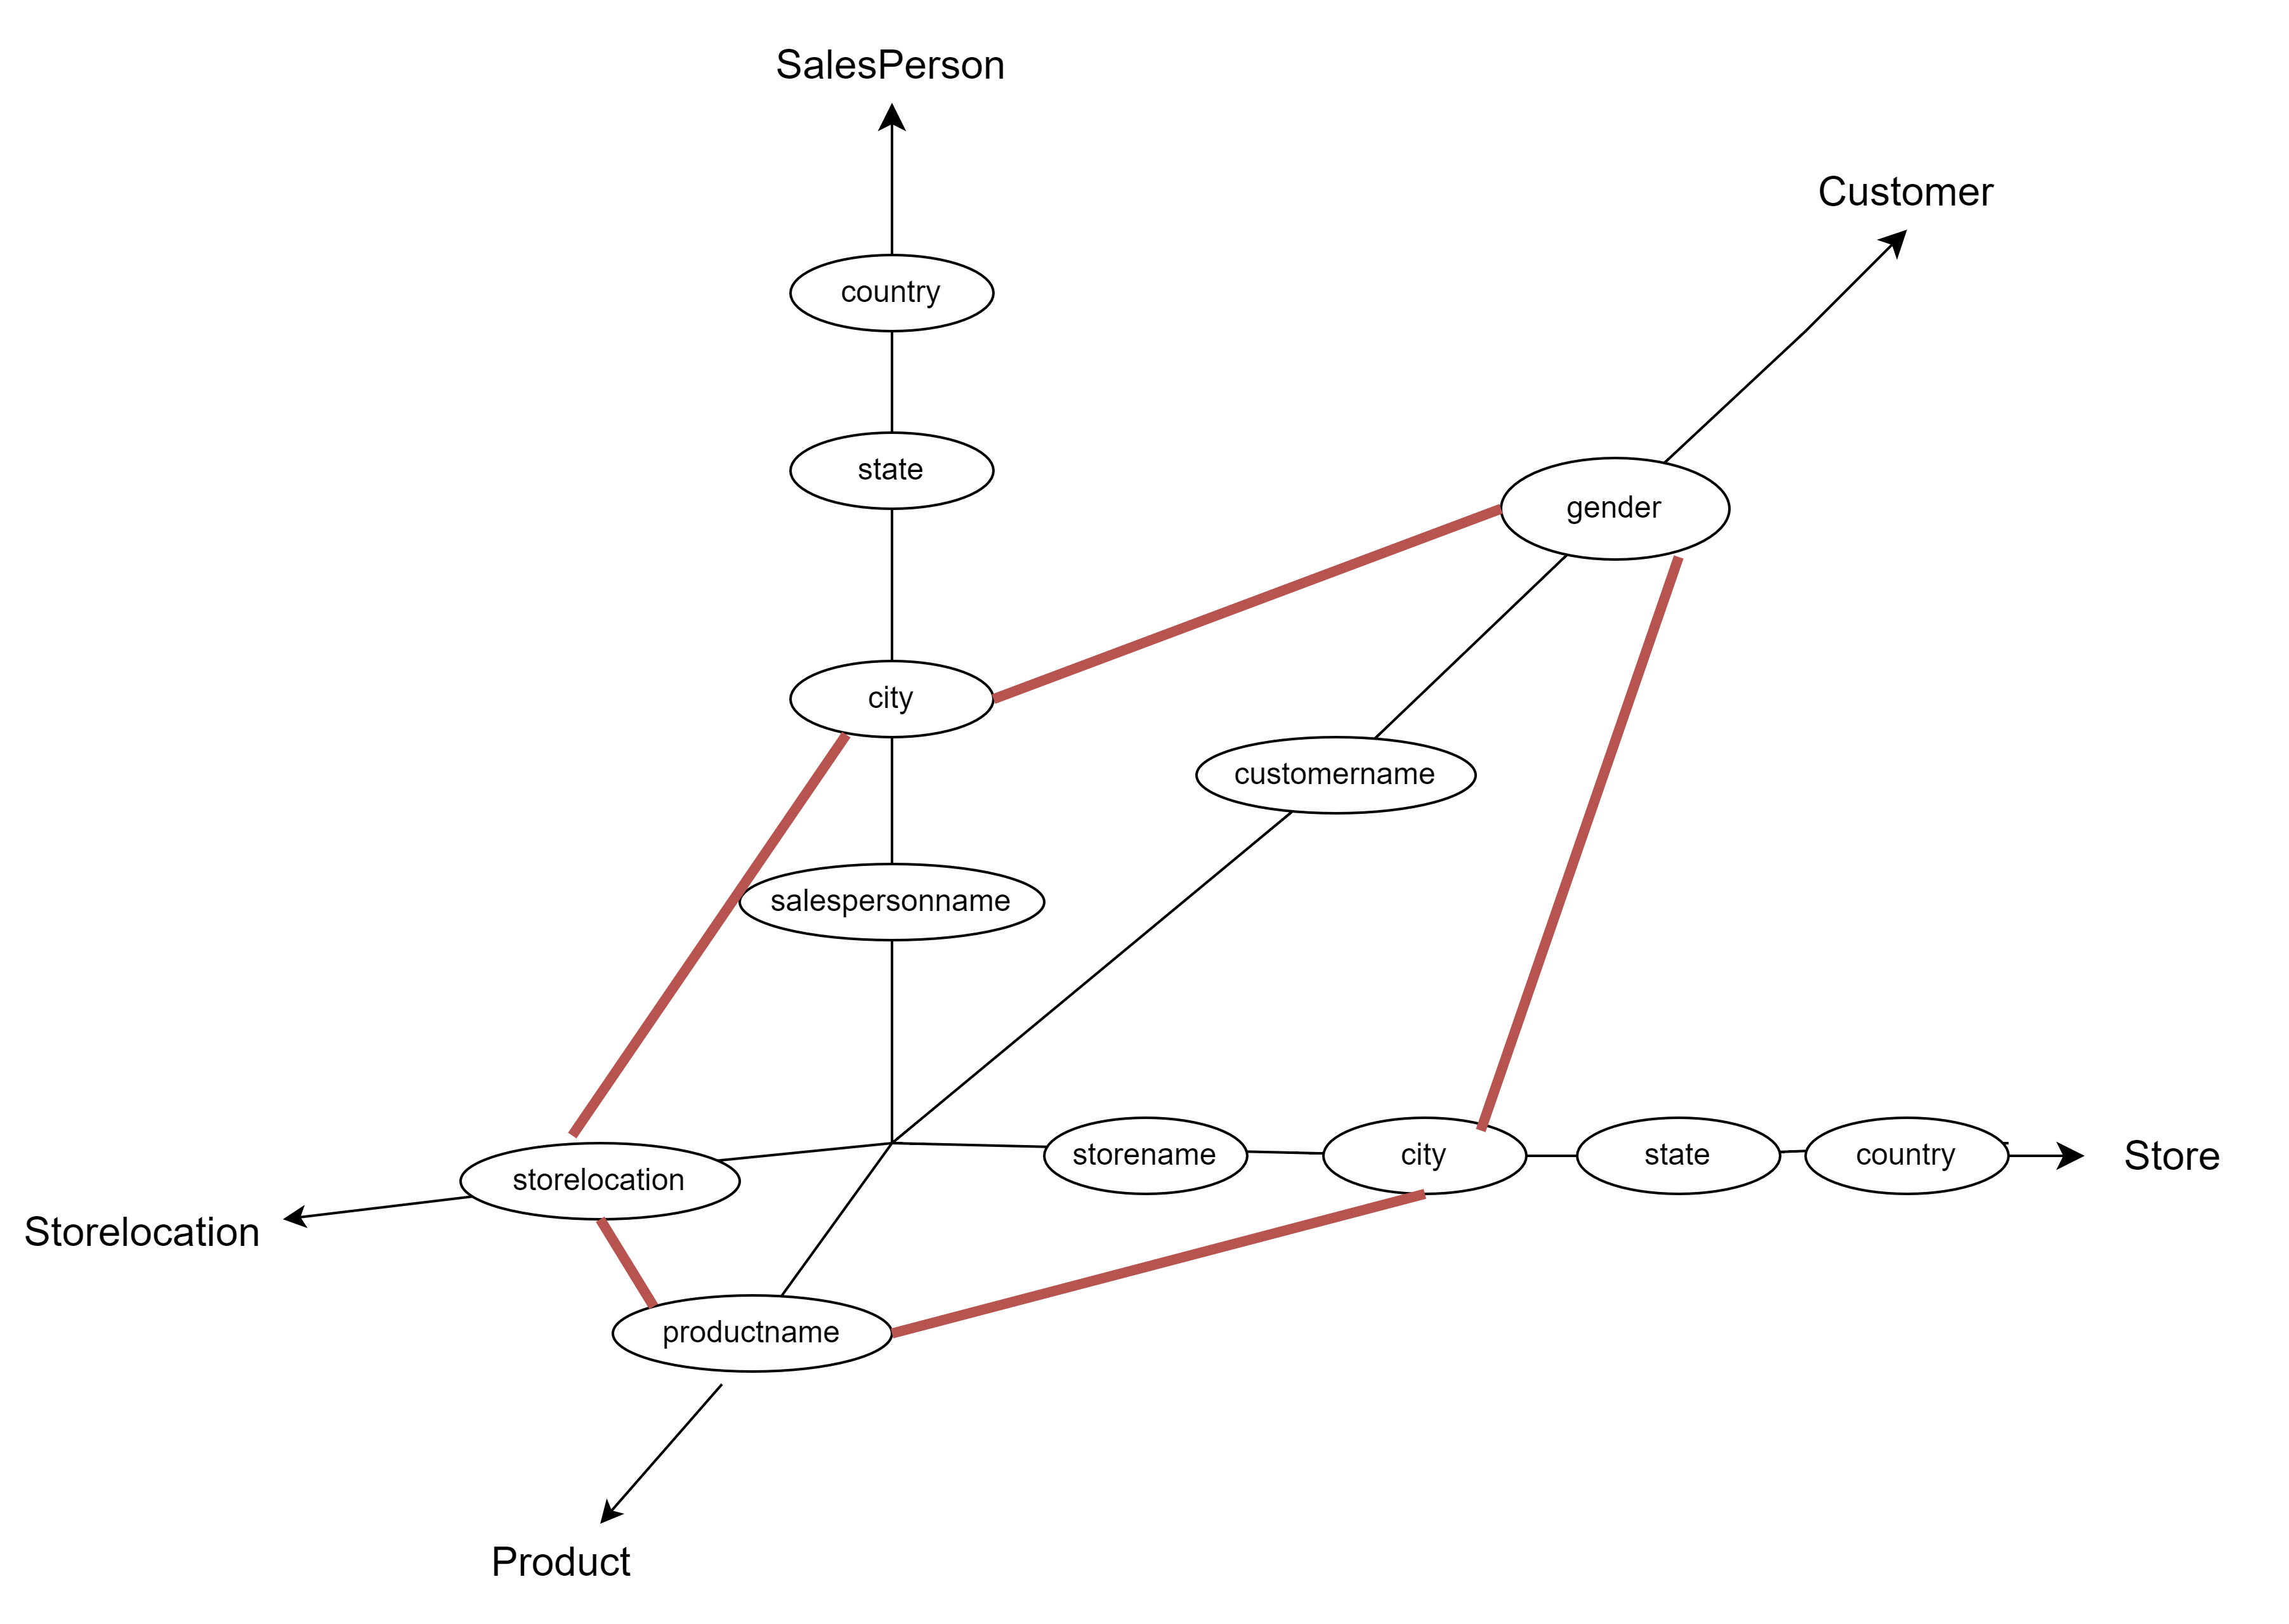

In [17]:
cube.query(measures["quantity.SUM"],
         levels=[levels[('Customer', 'Customer', 'gender')], levels[('Product', 'Product', 'productname')]])

quantity.SUM
customername  gender productname                          
Bill Gates    M      Nirma Soap                       6.00
                     Rice Grains 1kg                  1.00
                     SunFlower Oil 1 ltr              2.00
                     Wheat Floor 1kg                  1.00
Henry Ford    M      Arial Washing Powder 1kg         1.00
                     Nirma Soap                       6.00
                     Rice Grains 1kg                  3.00
                     SunFlower Oil 1 ltr              4.00
                     Wheat Floor 1kg                  4.00
Muskan Shaikh F      Arial Washing Powder 1kg         2.00
                     Nirma Soap                       6.00
                     Rice Grains 1kg                  4.00
                     SunFlower Oil 1 ltr              1.00
                     Wheat Floor 1kg                  2.00

In [18]:
cost = tt.agg.sum(
    measures["quantity.SUM"] * tt.agg.single_value(product_table["productactualcost"]),
    scope=tt.OriginScope(levels["productname"]),
)

income = tt.agg.sum(
    measures["quantity.SUM"] * tt.agg.single_value(product_table["productsalescost"]),
    scope=tt.OriginScope(levels["productname"]),
)
measures["Margin"] = income - cost

cube.query(measures["Margin"], levels=[levels[('Product', 'Product', 'productname')]])

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_dataclasses.py:135: FutureWarning: The variadic constructor is deprecated, pass a named `levels` parameter instead.
  s.__pydantic_validator__.validate_python(ArgsKwargs(args, kwargs), self_instance=s)


,Margin
productname,
Arial Washing Powder 1kg,12.00
Nirma Soap,36.00
Rice Grains 1kg,12.00
SunFlower Oil 1 ltr,10.50
Wheat Floor 1kg,7.00


## Visualize With Charts

In [19]:
session.link

http://localhost:34347

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

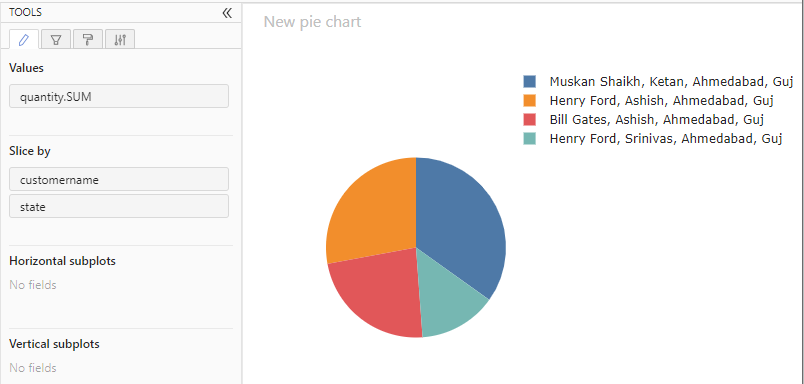

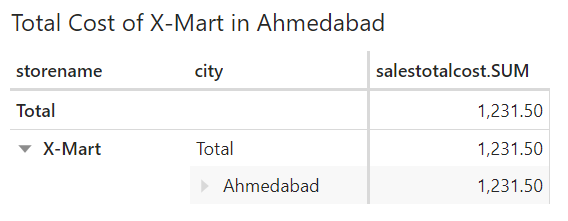

- Total cost of X-Mart in Ahmedabad is $1231.5.

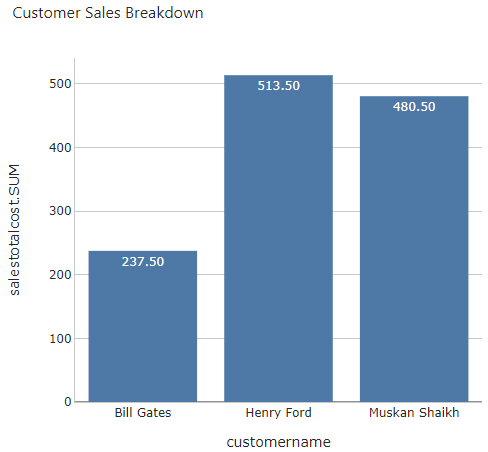 

- Henry Ford had the highest sales total cost.
- Might make Henry Ford and Muskan Shaikh VIP customers who could be targeted for loyalty programs or exclusive offers.
- Might reflect market trends or consumer preferences, showing that whatever Henry Ford represents is currently in demand.

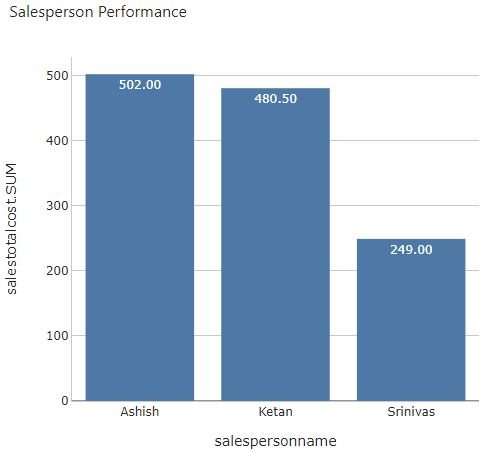
- Ashish has the highest total sales cost, currently the top-performing salesperson.
- Ashish has been able to sell products that cumulatively add up to the highest sales value.
- Ketan is also a strong performer, with only slightly lower total sales cost compared to Ashish.
- Srinivas has the lowest, which could suggest multiple things. It could be that Srinivas is handling lower-value sales, has lower opportunities, is newer to the team or may need additional support or training to increase performance.

Business decisions:
- potentially rewarded or used as case study for training for Ashish and Ketan's high performance
- resources like marketing support or inventory could be allocated differently based on individual performance.

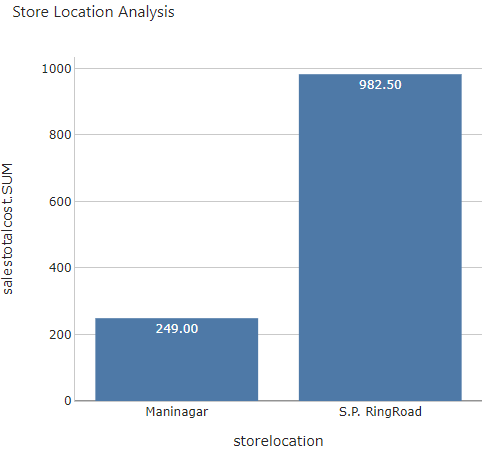
- Significant difference of sales between the 2 store location.
- Could be due to better location, higher foot traffic or more effective marketing.
- Might be better to invest more at S.P.RingRoad.
- S.P.RingRoad might have stocked products more in line with preferences of the customers.

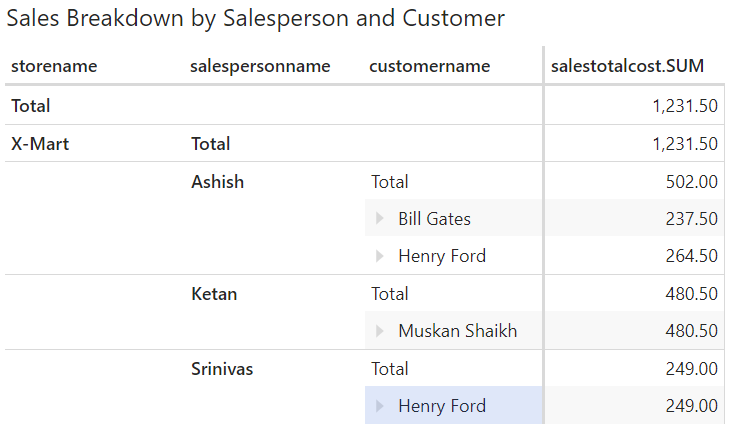
- with a closer look at the sales breakdown by salesperson and customer:
1. Salesperson Performance:
   - Ashish generated the most total sales cost from both Bill Gates and Henry Ford. Suggest good spread across different customers.
   - Ketan slightly lower but from a single customer. Suggests strong sales relationship with that customer.
   - Srinivas exclusively with Henry Ford. Henry repeat customer or Srinivas only focus on high-value clients.
2. Customer Contribution:
   - Henry Ford is a repeated customer, having made purchases with 2 different salesperson with highest overall contributer to the sale.
   - Muskan Shaikh, despite dealing with only Ketan, matches almost the sales amount that Henry Ford contributed with Ashish, indicate strong, possibly high-value transaction.
   - Bill Gates, having only dealt with Ashish, contributes the least in sales but still add significant amount, indicating diverse customer base.

In [20]:
session.tables.schema

```mermaid
erDiagram
  "Customer" {
    _ int PK "customerid"
    _ String "customeraltid"
    _ String "customername"
    _ String "gender"
  }
  "SalesPerson" {
    _ int PK "salespersonid"
    _ String "salespersonaltid"
    _ String "salespersonname"
    nullable int "storeid"
    _ String "city"
    _ String "state"
    _ String "country"
  }
  "Product" {
    _ int PK "productkey"
    _ String "productaltkey"
    _ String "productname"
    nullable double "productactualcost"
    nullable double "productsalescost"
  }
  "Stores" {
    _ int PK "storeid"
    _ String "storealtid"
    _ String "storename"
    _ String "storelocation"
    _ String "city"
    _ String "state"
    _ String "country"
  }
  "ProductSales" {
    _ long PK "transactionid"
    nullable int "salesinvoicenumber"
    nullable int "storeid"
    nullable int "customerid"
    nullable int "productid"
    nullable int "salespersonid"
    nullable double "quantity"
    nullable double "salestotalcost"
    nullable double "productactualcost"
    nullable double "deviation"
  }
  "ProductSales" }o--o| "Product" : "`productid` == `productkey`"
  "ProductSales" }o--o| "Customer" : "`customerid` == `customerid`"
  "ProductSales" }o--o| "SalesPerson" : "`salespersonid` == `salespersonid`"
  "ProductSales" }o--o| "Stores" : "`storeid` == `storeid`"
```
